In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import requests
import geopandas as gpd
import omnivida_loader as ov
import statsmodels.api         as sm
import statsmodels.formula.api as smf
%matplotlib inline

### Let's start by loading the cleansed datasets into pandas DataFrames. 

In [2]:
adherence, adherence_change = ov.get_adherence_dataset()
familiar_records = ov.get_family_records_dataset()

### Familiar records

In [3]:
familiar_records.head()

,id_patient,health_provider,creation_date,diagnosis,diagnosis_code,relationship,record_year
0,1998401,EPS/SURA,2012-07-09,"ASMA, NO ESPECIFICADA",J459,MADRE,2012
1,535255,EPS/SURA,2011-07-29,"DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION...",E149,ABUELO,2011
2,1004538,EPS/SURA,2012-01-17,HIPERTENSION ESENCIAL (PRIMARIA),I10X,PADRE,2012
3,788432,EPS/SURA,2012-01-06,HIPERTENSION ESENCIAL (PRIMARIA),I10X,PADRE,2012
4,788432,EPS/SURA,2012-01-06,HIPERTENSION ESENCIAL (PRIMARIA),I10X,MADRE,2012


In [4]:
familiar_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   id_patient       104 non-null    int64   
 1   health_provider  104 non-null    category
 2   creation_date    104 non-null    object  
 3   diagnosis        104 non-null    category
 4   diagnosis_code   104 non-null    category
 5   relationship     104 non-null    category
 6   record_year      104 non-null    int64   
dtypes: category(4), int64(2), object(1)
memory usage: 6.3+ KB


In [5]:
familiar_records.describe(include='all')

,id_patient,health_provider,creation_date,diagnosis,diagnosis_code,relationship,record_year
count,1.040000e+02,104,104,104,104,104,104.000000
unique,NaN,2,50,32,32,6,NaN
top,NaN,EPS/SURA,2011-09-13,HIPERTENSION ESENCIAL (PRIMARIA),I10X,MADRE,NaN
freq,NaN,99,6,30,30,35,NaN
mean,1.299300e+06,NaN,NaN,NaN,NaN,NaN,2012.721154
std,4.405538e+05,NaN,NaN,NaN,NaN,NaN,2.278889
min,5.294100e+05,NaN,NaN,NaN,NaN,NaN,2010.000000
25%,8.967585e+05,NaN,NaN,NaN,NaN,NaN,2011.000000
50%,1.280952e+06,NaN,NaN,NaN,NaN,NaN,2012.000000
75%,1.664806e+06,NaN,NaN,NaN,NaN,NaN,2013.000000


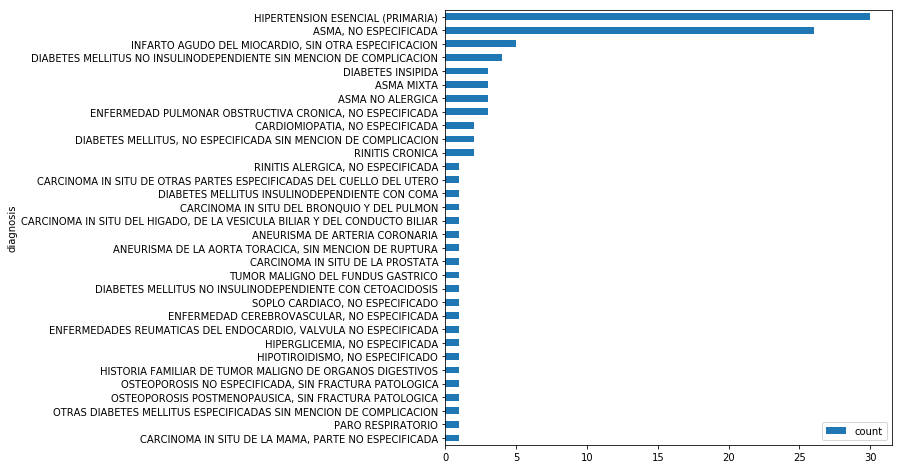

In [6]:
diagnosis = familiar_records[['id_patient', 'diagnosis']].groupby('diagnosis').size().sort_values(ascending=False).reset_index(name='count')
diagnosis.sort_values(by='count', ascending=True).plot(kind='barh', x='diagnosis', figsize=(8,8))

In [7]:
familiar_records.diagnosis.cat.categories

Index(['ANEURISMA DE ARTERIA CORONARIA',
       'ANEURISMA DE LA AORTA TORACICA, SIN MENCION DE RUPTURA', 'ASMA MIXTA',
       'ASMA NO ALERGICA', 'ASMA, NO ESPECIFICADA',
       'CARCINOMA IN SITU DE LA MAMA, PARTE NO ESPECIFICADA',
       'CARCINOMA IN SITU DE LA PROSTATA',
       'CARCINOMA IN SITU DE OTRAS PARTES ESPECIFICADAS DEL CUELLO DEL UTERO',
       'CARCINOMA IN SITU DEL BRONQUIO Y DEL PULMON',
       'CARCINOMA IN SITU DEL HIGADO, DE LA VESICULA BILIAR Y DEL CONDUCTO BILIAR',
       'CARDIOMIOPATIA, NO ESPECIFICADA', 'DIABETES INSIPIDA',
       'DIABETES MELLITUS INSULINODEPENDIENTE CON COMA',
       'DIABETES MELLITUS NO INSULINODEPENDIENTE CON CETOACIDOSIS',
       'DIABETES MELLITUS NO INSULINODEPENDIENTE SIN MENCION DE COMPLICACION',
       'DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION DE COMPLICACION',
       'ENFERMEDAD CEREBROVASCULAR, NO ESPECIFICADA',
       'ENFERMEDAD PULMONAR OBSTRUCTIVA CRONICA, NO ESPECIFICADA',
       'ENFERMEDADES REUMATICAS DEL ENDOCARDI

In [8]:
respiratory_related_diagnosis = ['ASMA MIXTA', 'ASMA NO ALERGICA', 'ASMA, NO ESPECIFICADA', 
                                 'CARCINOMA IN SITU DEL BRONQUIO Y DEL PULMON', 'ENFERMEDAD PULMONAR OBSTRUCTIVA CRONICA, NO ESPECIFICADA']

consolidated_family_record = pd.DataFrame()
for paciente, df in familiar_records.groupby('id_patient'):
    temp_df = df.copy()
    row = {}
    row['id_patient'] = int(paciente)
    row['family_history_reported'] = 1
    row['num_family_records'] = temp_df.shape[0]
    row['family_respiratory_related_diagnosis'] = len(temp_df[temp_df.diagnosis.isin(respiratory_related_diagnosis)])
    row['family_non_respiratory_related_diagnosis'] = len(temp_df[~temp_df.diagnosis.isin(respiratory_related_diagnosis)])
    consolidated_family_record = consolidated_family_record.append(row, ignore_index=True)

# Rearrange columns
consolidated_family_record = consolidated_family_record[
    ['id_patient', 'family_history_reported', 'num_family_records', 
     'family_respiratory_related_diagnosis', 'family_non_respiratory_related_diagnosis']
]

consolidated_family_record

,id_patient,family_history_reported,num_family_records,family_respiratory_related_diagnosis,family_non_respiratory_related_diagnosis
0,529410.0,1.0,1.0,0.0,1.0
1,535255.0,1.0,1.0,0.0,1.0
2,557377.0,1.0,1.0,0.0,1.0
3,664340.0,1.0,2.0,2.0,0.0
4,673765.0,1.0,1.0,1.0,0.0
5,674247.0,1.0,7.0,1.0,6.0
6,679525.0,1.0,1.0,0.0,1.0
7,716377.0,1.0,1.0,1.0,0.0
8,738900.0,1.0,1.0,0.0,1.0
9,788432.0,1.0,4.0,0.0,4.0


In [9]:
adherence.head()

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category
0,500547,2016-07-11,1,1,4,1,6.0,1,4,A
1,500547,2019-03-14,1,1,4,1,6.0,1,4,A
2,500547,2019-10-11,1,1,4,1,6.0,1,4,A
3,500547,2019-12-09,1,1,4,1,6.0,1,4,A
4,500547,2020-01-16,1,1,4,1,6.0,1,4,A


In [10]:
adherence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773 entries, 0 to 4772
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_patient           4773 non-null   int64         
 1   survey_date          4773 non-null   datetime64[ns]
 2   morisky_green        4773 non-null   object        
 3   smaq1                4773 non-null   object        
 4   smaq2                4773 non-null   object        
 5   espa                 4773 non-null   object        
 6   nm_espa              4773 non-null   float64       
 7   qualitative_result   4773 non-null   object        
 8   quantitative_result  4773 non-null   object        
 9   category             4773 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 340.6+ KB


In [11]:
adherence.describe(include='all')

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category
count,4.773000e+03,4773,4773.0,4773.0,4773.0,4773.0,4773.000000,4773.0,4773.0,4773
unique,NaN,1433,2.0,2.0,5.0,2.0,NaN,2.0,5.0,5
top,NaN,2019-04-30 00:00:00,1.0,1.0,4.0,1.0,NaN,1.0,4.0,A
freq,NaN,87,4052.0,3991.0,4311.0,3962.0,NaN,3785.0,4311.0,2317
first,NaN,2012-04-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-05-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.238178e+06,NaN,NaN,NaN,NaN,NaN,5.602975,NaN,NaN,NaN
std,4.296392e+05,NaN,NaN,NaN,NaN,NaN,0.911489,NaN,NaN,NaN
min,5.005470e+05,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
25%,8.716330e+05,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN


,id_patient,count_records
0,1769865,41
1,979605,30
2,1132214,28
3,622031,27
4,1676414,26
5,1196034,25
6,916510,25
7,1536265,23
8,1828862,23
9,1399081,23


4773


Text(0.5,1,'Number of adherence records per patient')

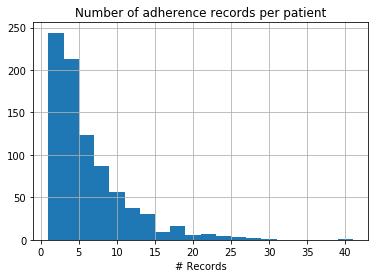

In [12]:
num_records_per_patient = adherence.groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count_records')
display(num_records_per_patient.head(10))
print(sum(num_records_per_patient['count_records']))
num_records_per_patient.hist('count_records', bins=20)
plt.xlabel('# Records')
plt.title('Number of adherence records per patient')

,category,count_records
0,A,2317
1,M,1285
2,A-,689
3,N+,472
4,N,10


4773


Text(0.5,1,'Number records per category')

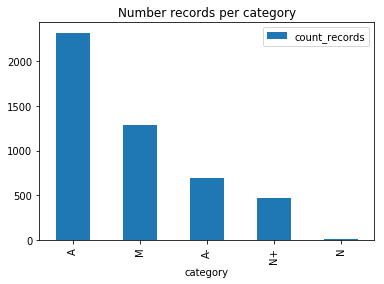

In [13]:
num_records_per_category = adherence.groupby('category').size().sort_values(ascending=False).reset_index(name='count_records')
display(num_records_per_category)
print(sum(num_records_per_category['count_records']))
num_records_per_category.plot(kind='bar', x='category')
# plt.xlabel('# Records')
plt.title('Number records per category')

In [14]:
adherence_change.head(10)

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category,morisky_change,smaq1_change,smaq2_change,espa_change,nm_espa_change,qualitative_result_change,quantitative_result_change,days_since_last_control,num_reports,ongoing_adherence_percentage
0,500547,2016-07-11,1,1,4,1,6.0,1,4,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,100.0
1,500547,2019-03-14,1,1,4,1,6.0,1,4,A,0,0,0,0,0.0,0,0,976.0,2,100.0
2,500547,2019-10-11,1,1,4,1,6.0,1,4,A,0,0,0,0,0.0,0,0,211.0,3,100.0
3,500547,2019-12-09,1,1,4,1,6.0,1,4,A,0,0,0,0,0.0,0,0,59.0,4,100.0
4,500547,2020-01-16,1,1,4,1,6.0,1,4,A,0,0,0,0,0.0,0,0,38.0,5,100.0
5,500547,2020-03-25,1,1,4,1,6.0,1,4,A,0,0,0,0,0.0,0,0,69.0,6,100.0
6,500547,2020-05-08,1,1,4,1,5.0,1,4,A,0,0,0,0,-1.0,0,0,44.0,7,100.0
7,500588,2019-04-26,1,1,4,1,6.0,1,4,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,100.0
8,502989,2014-08-22,0,0,2,1,5.0,0,2,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
9,502989,2014-10-28,0,0,2,0,5.0,0,2,M,0,0,0,-1,0.0,0,0,67.0,2,0.0


In [15]:
select_fields = ['id_patient', 'survey_date', 'category', 'qualitative_result', 'quantitative_result', 'qualitative_result_change', 'quantitative_result_change', 'days_since_last_control', 'ongoing_adherence_percentage']
adherence_change_analysis = adherence_change[select_fields]
adherence_change_analysis.head(30)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage
0,500547,2016-07-11,A,1,4,NaN,NaN,NaN,100.000000
1,500547,2019-03-14,A,1,4,0,0,976.0,100.000000
2,500547,2019-10-11,A,1,4,0,0,211.0,100.000000
3,500547,2019-12-09,A,1,4,0,0,59.0,100.000000
4,500547,2020-01-16,A,1,4,0,0,38.0,100.000000
5,500547,2020-03-25,A,1,4,0,0,69.0,100.000000
6,500547,2020-05-08,A,1,4,0,0,44.0,100.000000
7,500588,2019-04-26,A,1,4,NaN,NaN,NaN,100.000000
8,502989,2014-08-22,M,0,2,NaN,NaN,NaN,0.000000
9,502989,2014-10-28,M,0,2,0,0,67.0,0.000000


In [16]:
adherence_change_analysis_pivot = adherence_change_analysis.copy()
adherence_change_analysis_pivot['survey_month'] = adherence_change_analysis_pivot['survey_date'].dt.month
adherence_change_analysis_pivot['survey_year'] = adherence_change_analysis_pivot['survey_date'].dt.year
adherence_pivot_dias_control = pd.pivot_table(adherence_change_analysis_pivot, values='days_since_last_control', index='survey_month', columns='survey_year', aggfunc='mean')
adherence_pivot_adher_percentage = pd.pivot_table(adherence_change_analysis_pivot, values='ongoing_adherence_percentage', index='survey_month', columns='survey_year', aggfunc='mean')

Text(0.5,1,'Dias desde el ultimo control')

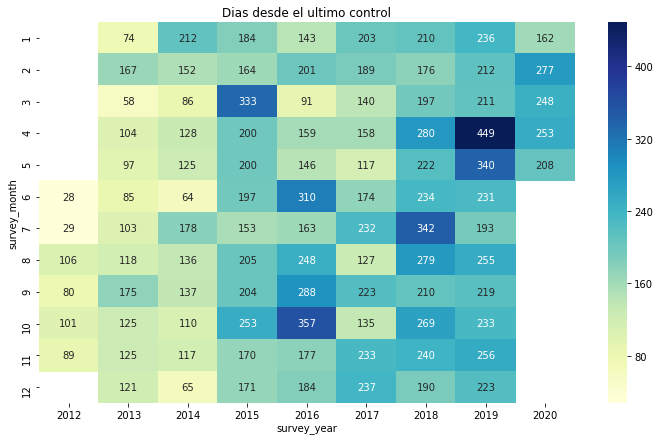

In [17]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_dias_control, ax=ax, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Dias desde el ultimo control')

Text(0.5,1,'Porcentage de adherencia historico promedio por mes')

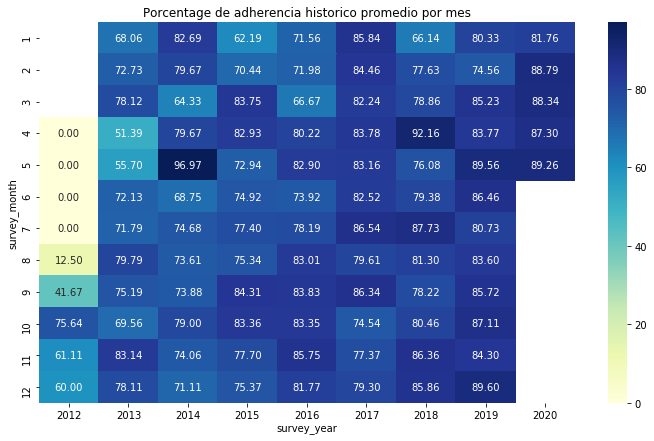

In [18]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_adher_percentage, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Porcentage de adherencia historico promedio por mes')

#### Let's have a look at those patients that went from `adherent` (i.e. 1 in the `cualitativo_ponderado` field) to `non-adherent` (i.e. 1 in the `cualitativo_ponderado` field) 

In [19]:
neg_transition = adherence_change_analysis[adherence_change_analysis['qualitative_result_change']==-1]
neg_transition.head(10)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage
14,502989,2016-01-12,M,0,3,-1,-1,201.0,14.285714
16,502989,2017-01-03,M,0,3,-1,-1,354.0,22.222222
20,502989,2018-10-03,M,0,4,-1,0,421.0,38.461538
35,506808,2018-10-08,M,0,4,-1,0,131.0,85.714286
44,512938,2018-05-04,M,0,4,-1,0,216.0,85.714286
48,512938,2019-09-30,M,0,1,-1,-3,293.0,72.727273
51,514102,2018-01-30,A,0,4,-1,0,74.0,66.666667
55,524006,2015-10-13,A-,0,4,-1,0,33.0,66.666667
62,524006,2017-05-10,A-,0,3,-1,-1,28.0,70.000000
93,529410,2018-01-30,A-,0,4,-1,0,122.0,66.666667


In [20]:
neg_transition_count = neg_transition.groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count_neg_transitions')
neg_transition_count.head(10)

,id_patient,count_neg_transitions
0,1769865,7
1,832593,7
2,622031,6
3,739693,6
4,673765,6
5,916510,6
6,1828862,5
7,1132214,5
8,747471,5
9,801004,5


Text(0.5,1,'Number of negative transitions per month')

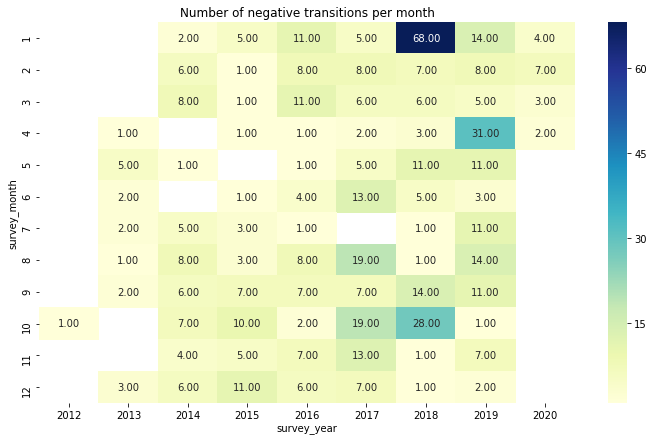

In [21]:
neg_transition_pivot = neg_transition.copy()
neg_transition_pivot['survey_month'] = neg_transition_pivot['survey_date'].dt.month
neg_transition_pivot['survey_year'] = neg_transition_pivot['survey_date'].dt.year
neg_transition_pivot = pd.pivot_table(neg_transition_pivot, values='id_patient', index='survey_month', columns='survey_year', aggfunc='count')

fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(neg_transition_pivot, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Number of negative transitions per month')

#### Let's have a look at those patients that went from `non-adherent` (i.e. 0 in the `cualitativo_ponderado` field) to `adherent` (i.e. 1 in the `cualitativo_ponderado` field) 

In [22]:
pos_transition = adherence_change_analysis[adherence_change_analysis['qualitative_result_change']==1]
pos_transition.head(10)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage
13,502989,2015-06-25,M,1,4,1,1,162.0,16.666667
15,502989,2016-01-15,M,1,4,1,1,3.0,25.000000
17,502989,2017-03-21,M,1,4,1,1,77.0,30.000000
21,502989,2019-02-08,M,1,4,1,0,128.0,42.857143
23,506808,2013-05-24,M,1,4,1,0,16.0,50.000000
37,506808,2019-06-14,M,1,4,1,4,113.0,81.250000
46,512938,2018-11-14,M,1,4,1,0,42.0,77.777778
52,514102,2018-09-25,A,1,4,1,0,238.0,75.000000
57,524006,2016-06-02,A-,1,4,1,0,206.0,60.000000
63,524006,2017-07-28,A-,1,4,1,1,79.0,72.727273


In [23]:
pos_transition_count = pos_transition.groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count_pos_transitions')
pos_transition_count.head(10)

,id_patient,count_pos_transitions
0,1769865,8
1,832593,7
2,622031,7
3,673765,6
4,739693,6
5,1132214,6
6,747471,5
7,1399081,5
8,916510,5
9,801004,5


Text(0.5,1,'Number of positive transitions per month')

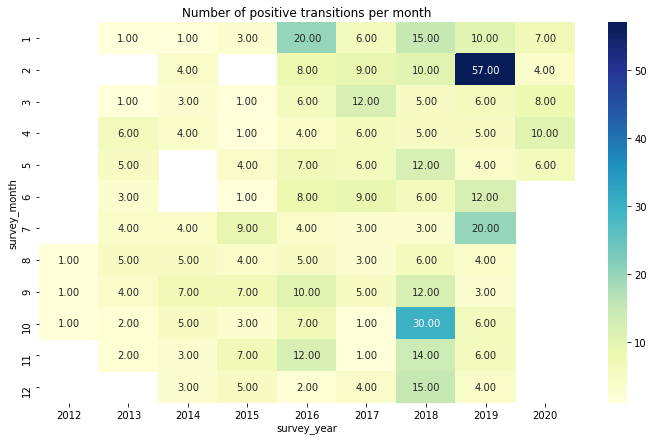

In [24]:
pos_transition_pivot = pos_transition.copy()
pos_transition_pivot['survey_month'] = pos_transition_pivot['survey_date'].dt.month
pos_transition_pivot['survey_year'] = pos_transition_pivot['survey_date'].dt.year
pos_transition_pivot = pd.pivot_table(pos_transition_pivot, values='id_patient', index='survey_month', columns='survey_year', aggfunc='count')

fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(pos_transition_pivot, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Number of positive transitions per month')

#### Let's get the last reported adherence status for each of the users in the available dataset

In [25]:
last_reported_adherence = pd.DataFrame()
for paciente, df in adherence_change.groupby('id_patient'):
    temp_df = df.copy()
    row = {}
    row['id_patient'] = int(paciente)
    row['num_reports'] = temp_df.shape[0]
    row['qualitative_result'] = temp_df.iloc[-1]['qualitative_result']
    row['quantitative_result'] = temp_df.iloc[-1]['quantitative_result']
    row['category'] = temp_df.iloc[0]['category']
    row['avg_days_since_last_control'] = temp_df['days_since_last_control'].mean()
    row['ongoing_adherence_percentage'] = temp_df.iloc[-1]['ongoing_adherence_percentage']
    last_reported_adherence = last_reported_adherence.append(row, ignore_index=True)

# Rearrange columns
last_reported_adherence = last_reported_adherence[
    ['id_patient', 'num_reports', 'qualitative_result', 
     'quantitative_result', 'avg_days_since_last_control', 'ongoing_adherence_percentage', 'category']
]

display(last_reported_adherence.head(10))
last_reported_adherence.shape

,id_patient,num_reports,qualitative_result,quantitative_result,avg_days_since_last_control,ongoing_adherence_percentage,category
0,500547.0,7.0,1.0,4.0,232.833333,100.000000,A
1,500588.0,1.0,1.0,4.0,NaN,100.000000,A
2,502989.0,14.0,1.0,4.0,125.461538,42.857143,M
3,506808.0,16.0,1.0,4.0,148.533333,81.250000,M
4,512938.0,11.0,0.0,1.0,167.900000,72.727273,M
5,514102.0,4.0,1.0,4.0,625.333333,75.000000,A
6,524006.0,14.0,1.0,4.0,123.384615,78.571429,A-
7,524902.0,1.0,1.0,4.0,NaN,100.000000,A
8,525295.0,2.0,1.0,4.0,173.000000,100.000000,A
9,525540.0,1.0,1.0,4.0,NaN,100.000000,A


(840, 7)

#### Let's study the influence of familiar health background on patients adherence

In [26]:
familiar_record_adherence = last_reported_adherence.merge(consolidated_family_record, how='left', on='id_patient')
familiar_record_adherence['category'] = familiar_record_adherence['category'].astype('category')
familiar_record_adherence['category'].cat.reorder_categories(['N', 'N+', 'M', 'A-', 'A'], ordered=True, inplace=True)
familiar_record_adherence['family_history_reported'] = familiar_record_adherence['family_history_reported'].fillna(0)

In [27]:
familiar_record_adherence.head(20)

,id_patient,num_reports,qualitative_result,quantitative_result,avg_days_since_last_control,ongoing_adherence_percentage,category,family_history_reported,num_family_records,family_respiratory_related_diagnosis,family_non_respiratory_related_diagnosis
0,500547.0,7.0,1.0,4.0,232.833333,100.000000,A,0.0,NaN,NaN,NaN
1,500588.0,1.0,1.0,4.0,NaN,100.000000,A,0.0,NaN,NaN,NaN
2,502989.0,14.0,1.0,4.0,125.461538,42.857143,M,0.0,NaN,NaN,NaN
3,506808.0,16.0,1.0,4.0,148.533333,81.250000,M,0.0,NaN,NaN,NaN
4,512938.0,11.0,0.0,1.0,167.900000,72.727273,M,0.0,NaN,NaN,NaN
5,514102.0,4.0,1.0,4.0,625.333333,75.000000,A,0.0,NaN,NaN,NaN
6,524006.0,14.0,1.0,4.0,123.384615,78.571429,A-,0.0,NaN,NaN,NaN
7,524902.0,1.0,1.0,4.0,NaN,100.000000,A,0.0,NaN,NaN,NaN
8,525295.0,2.0,1.0,4.0,173.000000,100.000000,A,0.0,NaN,NaN,NaN
9,525540.0,1.0,1.0,4.0,NaN,100.000000,A,0.0,NaN,NaN,NaN


In [28]:
familiar_record_adherence.shape

(840, 11)

In [29]:
adherence_with_reported_familiar_history = familiar_record_adherence[familiar_record_adherence['family_history_reported']==1]
adherence_no_reported_familiar_history = familiar_record_adherence[familiar_record_adherence['family_history_reported']==0]

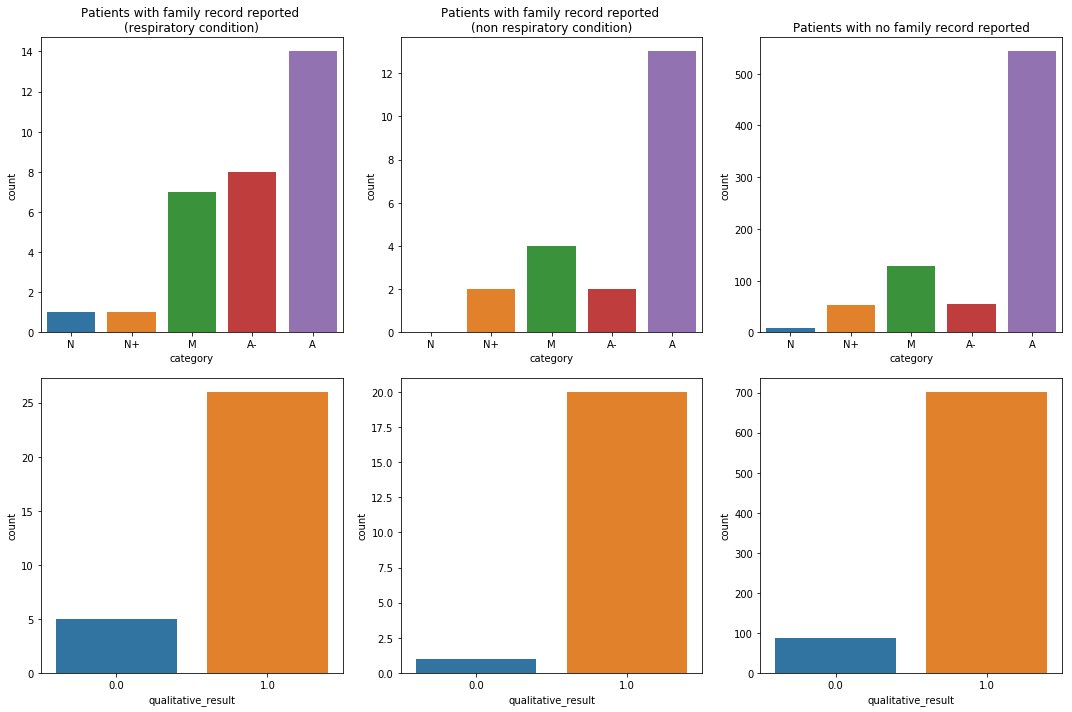

In [30]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
sns.barplot(data=adherence_with_reported_familiar_history[adherence_with_reported_familiar_history['family_respiratory_related_diagnosis'] > 0].groupby('category').size().reset_index(name='count'), x='category', y='count')
plt.title('Patients with family record reported \n(respiratory condition)')
plt.subplot(2,3,2)
sns.barplot(data=adherence_with_reported_familiar_history[adherence_with_reported_familiar_history['family_respiratory_related_diagnosis'] == 0].groupby('category').size().reset_index(name='count'), x='category', y='count')
plt.title('Patients with family record reported \n(non respiratory condition)')
plt.subplot(2,3,3)
sns.barplot(data=adherence_no_reported_familiar_history.groupby('category').size().reset_index(name='count'), x='category', y='count')
plt.title('Patients with no family record reported')
plt.subplot(2,3,4)
sns.barplot(data=adherence_with_reported_familiar_history[adherence_with_reported_familiar_history['family_respiratory_related_diagnosis'] > 0].groupby('qualitative_result').size().reset_index(name='count'), x='qualitative_result', y='count')
plt.subplot(2,3,5)
sns.barplot(data=adherence_with_reported_familiar_history[adherence_with_reported_familiar_history['family_respiratory_related_diagnosis'] == 0].groupby('qualitative_result').size().reset_index(name='count'), x='qualitative_result', y='count')
plt.subplot(2,3,6)
sns.barplot(data=adherence_no_reported_familiar_history.groupby('qualitative_result').size().reset_index(name='count'), x='qualitative_result', y='count')
plt.tight_layout()

In [31]:
adherence_with_reported_familiar_history_resp = adherence_with_reported_familiar_history[adherence_with_reported_familiar_history['family_respiratory_related_diagnosis'] > 0]
adherence_with_reported_familiar_history_no_resp = adherence_with_reported_familiar_history[adherence_with_reported_familiar_history['family_respiratory_related_diagnosis'] == 0]

In [33]:
avg_adherence_familiar_history_resp = adherence_with_reported_familiar_history_resp.ongoing_adherence_percentage.mean() 
avg_adherence_familiar_history_no_resp = adherence_with_reported_familiar_history_no_resp.ongoing_adherence_percentage.mean()
avg_adherence_no_familiar_reports = adherence_no_reported_familiar_history.ongoing_adherence_percentage.mean()

In [34]:
print(f"Average ongoing adherence for patients with relatives with respiratory conditions: {round(avg_adherence_familiar_history_resp, 2)}")
print(f"Average ongoing adherence for patients with relatives with conditions other than respiratory: {round(avg_adherence_familiar_history_no_resp, 2)}")
print(f"Average ongoing adherence for patients which haven't report any familiar history: {round(avg_adherence_no_familiar_reports, 2)}")

Average ongoing adherence for patients with relatives with respiratory conditions: 73.82
Average ongoing adherence for patients with relatives with conditions other than respiratory: 87.09
Average ongoing adherence for patients which haven't report any familiar history: 84.77


In [35]:
adherence_with_reported_familiar_history_resp.ongoing_adherence_percentage.describe()

count     31.000000
mean      73.821767
std       22.091677
min        0.000000
25%       60.000000
50%       77.272727
75%       90.598291
max      100.000000
Name: ongoing_adherence_percentage, dtype: float64

In [36]:
adherence_with_reported_familiar_history_no_resp.ongoing_adherence_percentage.describe()

count     21.000000
mean      87.087300
std       16.579633
min       50.000000
25%       76.923077
50%      100.000000
75%      100.000000
max      100.000000
Name: ongoing_adherence_percentage, dtype: float64

In [37]:
adherence_no_reported_familiar_history.ongoing_adherence_percentage.describe()

count    788.000000
mean      84.765532
std       20.509288
min        0.000000
25%       75.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: ongoing_adherence_percentage, dtype: float64

Text(0.5,1,'Patients with no family record reported')

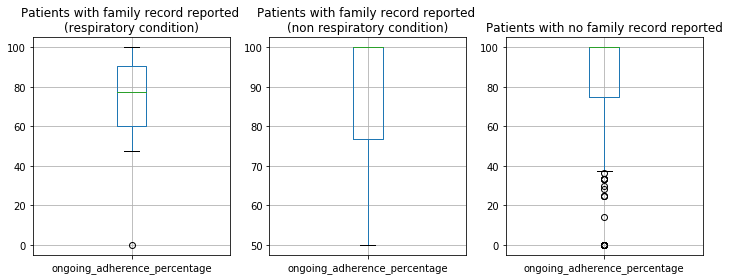

In [38]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
adherence_with_reported_familiar_history_resp.boxplot(column=['ongoing_adherence_percentage'])
plt.title('Patients with family record reported \n(respiratory condition)')
plt.subplot(1,3,2)
adherence_with_reported_familiar_history_no_resp.boxplot(column=['ongoing_adherence_percentage'])
plt.title('Patients with family record reported \n(non respiratory condition)')
plt.subplot(1,3,3)
adherence_no_reported_familiar_history.boxplot(column=['ongoing_adherence_percentage'])
plt.title('Patients with no family record reported')

In [39]:
from scipy import stats

statistic, pvalue = stats.ttest_ind(adherence_with_reported_familiar_history_resp.ongoing_adherence_percentage, adherence_with_reported_familiar_history_no_resp.ongoing_adherence_percentage, equal_var=False, nan_policy='omit')
statistic, pvalue

(-2.4704703231622016, 0.01699143605925183)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


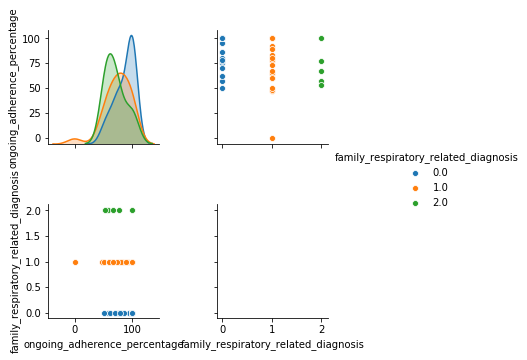

In [40]:
sns.pairplot(familiar_record_adherence[['ongoing_adherence_percentage', 'family_respiratory_related_diagnosis']], hue='family_respiratory_related_diagnosis')

In [31]:
familiar_record_non_adherent_patients = familiar_record_adherence[(familiar_record_adherence['quantitative_result'] < 4) & (familiar_record_adherence['qualitative_result']==0)]
familiar_record_non_adherent_patients

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,diagnosis,relationship
8,502989,2014-08-22,M,0,2,NaN,NaN,NaN,0.00,NaN,NaN
9,502989,2014-10-28,M,0,2,0.0,0.0,67.0,0.00,NaN,NaN
11,502989,2015-01-07,M,0,3,0.0,-1.0,47.0,0.00,NaN,NaN
12,502989,2015-01-14,M,0,3,0.0,0.0,7.0,0.00,NaN,NaN
14,502989,2016-01-12,M,0,3,-1.0,-1.0,201.0,14.29,NaN,NaN
16,502989,2017-01-03,M,0,3,-1.0,-1.0,354.0,22.22,NaN,NaN
36,506808,2019-02-21,M,0,0,0.0,-4.0,136.0,80.00,NaN,NaN
48,512938,2019-09-30,M,0,1,-1.0,-3.0,293.0,72.73,NaN,NaN
62,524006,2017-05-10,A-,0,3,-1.0,-1.0,28.0,70.00,NaN,NaN
94,529410,2019-02-14,A-,0,3,0.0,-1.0,380.0,57.14,HIPERTENSION ESENCIAL (PRIMARIA),ABUELA


In [29]:
familiar_record_adherent_patients = familiar_record_adherence[(familiar_record_adherence['quantitative_result'] == 4) & (familiar_record_adherence['qualitative_result']==1)]
familiar_record_adherent_patients

,id_patient,fe_entrevista,categoria,cualitativo_ponderado,cuantitativo_ponderado,cualitativo_ponderado_change,cuantitativo_ponderado_change,dias_ultimo_control,historico_porcentaje_adherencia,diagnosis,relationship
0,500547,2016-07-11,A,1,4,NaN,NaN,NaN,100.00,NaN,NaN
1,500547,2019-03-14,A,1,4,0.0,0.0,976.0,100.00,NaN,NaN
2,500547,2019-10-11,A,1,4,0.0,0.0,211.0,100.00,NaN,NaN
3,500547,2019-12-09,A,1,4,0.0,0.0,59.0,100.00,NaN,NaN
4,500547,2020-01-16,A,1,4,0.0,0.0,38.0,100.00,NaN,NaN
5,500547,2020-03-25,A,1,4,0.0,0.0,69.0,100.00,NaN,NaN
6,500547,2020-05-08,A,1,4,0.0,0.0,44.0,100.00,NaN,NaN
7,500588,2019-04-26,A,1,4,NaN,NaN,NaN,100.00,NaN,NaN
13,502989,2015-06-25,M,1,4,1.0,1.0,162.0,16.67,NaN,NaN
15,502989,2016-01-15,M,1,4,1.0,1.0,3.0,25.00,NaN,NaN


In [32]:
adherence[adherence['id_patient']==1012279]

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category
1666,1012279,2018-07-27,1,1,4,1,6.0,1,4,M
1667,1012279,2019-06-11,0,0,3,1,5.0,0,3,M
1668,1012279,2019-07-16,1,1,4,1,6.0,1,4,M
1669,1012279,2020-02-22,1,1,4,0,5.0,0,4,M


In [31]:
print(familiar_record_adherent_patients.shape)
print(familiar_record_non_adherent_patients.shape)

(4106, 11)
(478, 11)
